In [2]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [3]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_rec = load_file(
    '../../data/comfort/2018-04-23_12-30-38.csv', bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    '../../data/comfort/2018-04-23-12-17-37_0.pkl.gz')

r = Record(lidar_rec, bicycle_rec)

In [4]:
# manually sync to save time
r.synced = 18.512

In [5]:
r.sync()
r.bicycle

rec.array([ (  0.00000000e+00, -0.67684991,  0.00125928, -0.22684015, -1.81434514,  9.40658534,  0.01052403, -0.00695461, -0.00039456,  0.),
           (  7.99100000e-03, -0.67684991,  0.00125928, -0.22870405, -1.83043354,  9.40952834,  0.00823904, -0.00625159, -0.00203412,  0.),
           (  1.59910000e-02, -0.67684991,  0.00125928, -0.22232755, -1.86937924,  9.42120224,  0.00823904, -0.00343917, -0.00039456,  0.),
           ...,
           (  2.01755767e+03, -0.20358242,  0.00125928, -0.26725735, -1.20023914,  9.52067564,  0.00419634, -0.00396661,  0.00920912,  0.),
           (  2.01756567e+03, -0.20579395,  0.00125928, -0.23586535, -1.34395564,  9.52822934,  0.0057783 , -0.00466963,  0.00417297,  0.),
           (  2.01757367e+03, -0.20579395,  0.00125928, -0.20251135, -1.33159504,  9.49114754,  0.00191135, -0.00414236, -0.000863  ,  0.)], 
          dtype=[('time', '<f8'), ('steer angle', '<f8'), ('speed', '<f8'), ('accelerometer x', '<f8'), ('accelerometer y', '<f8'), ('acceler

<IPython.core.display.Javascript object>


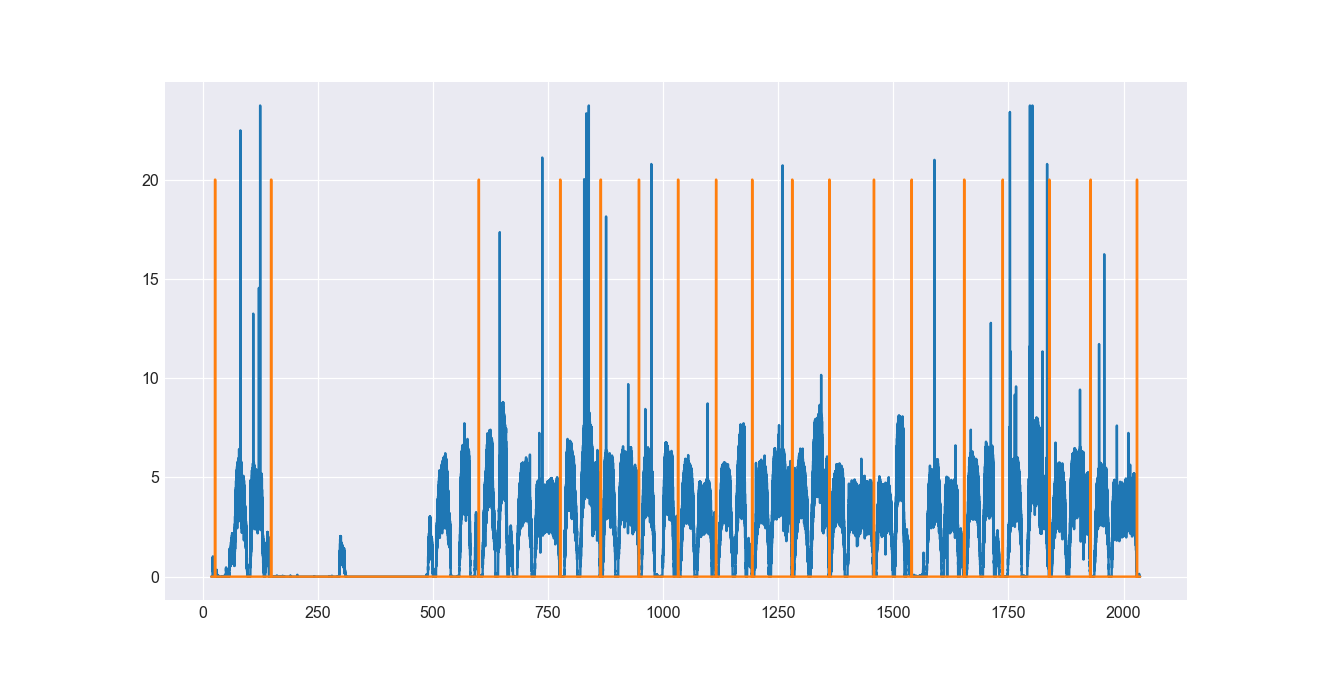

In [4]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close('all')
fig, ax = plt.subplots()
ax.plot(r.bicycle.time, r.bicycle.speed)
ax.plot(r.bicycle.time, 20*r.bicycle.sync)
plt.show()

<IPython.core.display.Javascript object>


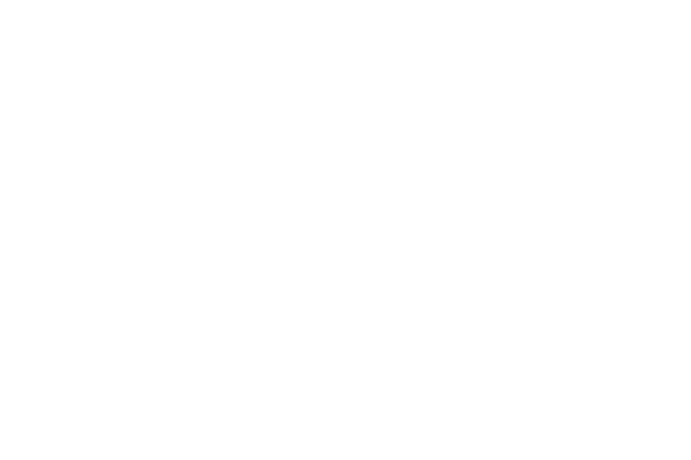

In [5]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())
    
display_animation(r.lidar.frame(lambda t: (t > 1172) & (t < 1190)).animate(
    xlim=(-40, 110),
    ylim=(0, 4),
    rlim=(0, 110)))

<IPython.core.display.Javascript object>


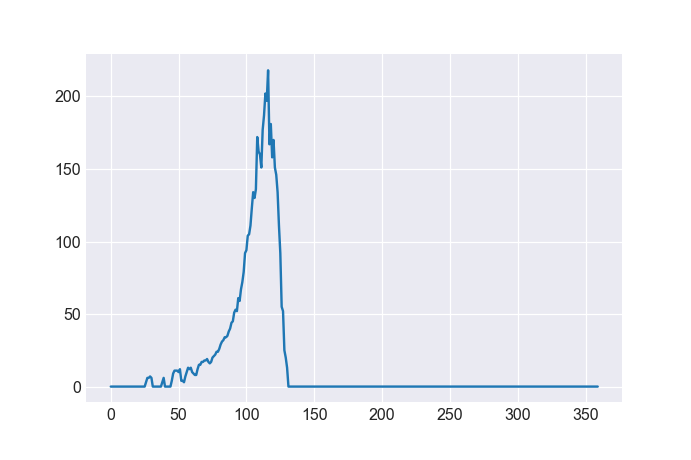

In [6]:
x, y = r.lidar.frame(lambda t: (t > 1172) & (t < 1190)).cartesian(xlim=(0, 110), ylim=(0, 4))

plt.close('all')
fig, ax = plt.subplots()
ax.plot(x.count(axis=1))
plt.show()

In [31]:
# get subrecord from bicycle data (high frequency)
hf_range = np.where(r.bicycle.sync > 0)[0][[0, -1]]
print(hf_range)

# get equivalent start point in lidar data (low frequency)
# in_view = r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1
lf_start = np.where(r.lidar.sync > 0)[0][0]
print(lf_start)

hf_time = r.bicycle.time[hf_range[0]:hf_range[-1]]
hf_time -= hf_time[0]

lf_time = r.lidar.time[lf_start:]
lf_time -= lf_time[0]

lf_lidar_inrange = r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1
hf_lidar_inrange = np.interp(hf_time, lf_time, lf_lidar_inrange[lf_start:])

# event mask is at high frequency
event_mask = np.logical_and(hf_lidar_inrange, (r.bicycle.speed > 1)[hf_range[0]:hf_range[-1]])

[   981 250535]
526


In [32]:
def debounce(x, decay=100):
    assert x[0] == 0
    assert x[-1] == 0
    
    edges = np.zeros(x.shape)
    edges[1:] = np.diff(x.astype(int))
    
    for i in range(edges.shape[0]):
        if edges[i] == -1:
            for j in range(decay):
                if edges[i + j] == 1:
                    edges[i] = 0
                    edges[i + j] = 0
                    break
    
    return np.cumsum(edges)

# split by sync signal
def event_indices(x, rising_start=True):
    edges = np.diff(x.astype(int))
    rising = np.where(edges > 0)[0]
    falling = np.where(edges < 0)[0]
    print('rising indices', rising)
    print('falling indices', falling)
    assert len(rising) == len(falling)
    
    if not rising_start:
        # ignore first rising edge and last falling edge
        return list(zip(falling[:-1], rising[1:]))
    
    return list(zip(rising, falling))
    
trials = event_indices(r.bicycle.sync, rising_start=False)
events = event_indices(debounce(event_mask))
trials = [(t0 - hf_range[0], t1 - hf_range[0]) for t0, t1 in trials]

te = []
for ti in trials:
    x = event_mask[ti[0]-10:ti[1]+10]
    y = r.bicycle.sync[ti[0]-10:ti[1]+10]
    
    print()
    print('trial', ti, r.bicycle.time[ti[0]], r.bicycle.time[ti[1]])
    events = event_indices(debounce(event_mask)[ti[0]:ti[1]])
    events = [e for e in events if e[1] - e[0] > 100] # minumum size
    print('trial events', events)
    te.append((events[-1][0] + ti[0], events[-1][1] + ti[0]))

rising indices [   980  16138  72351  94384 105321 115684 126274 136569 146345 157180
 167252 179312 189529 203754 214195 226809 237998 250466]
falling indices [  1099  16272  72434  94480 105449 115775 126389 136653 146438 157286
 167352 179386 189613 203858 214261 226875 238058 250535]
rising indices [ 11928  68193  70905  78284  83658  89145 100698 111233 115711 123186
 133232 142892 152668 163119 173971 185804 192792 196085 200009 210005
 221847 233393 245362]
falling indices [ 13109  69077  70936  79047  84058  90295 101316 112092 117717 124073
 134351 143554 153449 163756 175083 186561 194596 196547 201134 210818
 222416 234193 246450]

trial (118, 15157) 0.94411 113.642291
rising indices [11810]
falling indices [12991]
trial events [(11810, 12991)]

trial (15291, 71370) 114.722426 565.126056
rising indices [52902 55614]
falling indices [53786 55645]
trial events [(52902, 53786)]

trial (71453, 93403) 565.79014 741.820273
rising indices [ 6831 12205 17692]
falling indices [ 7594 

<IPython.core.display.Javascript object>


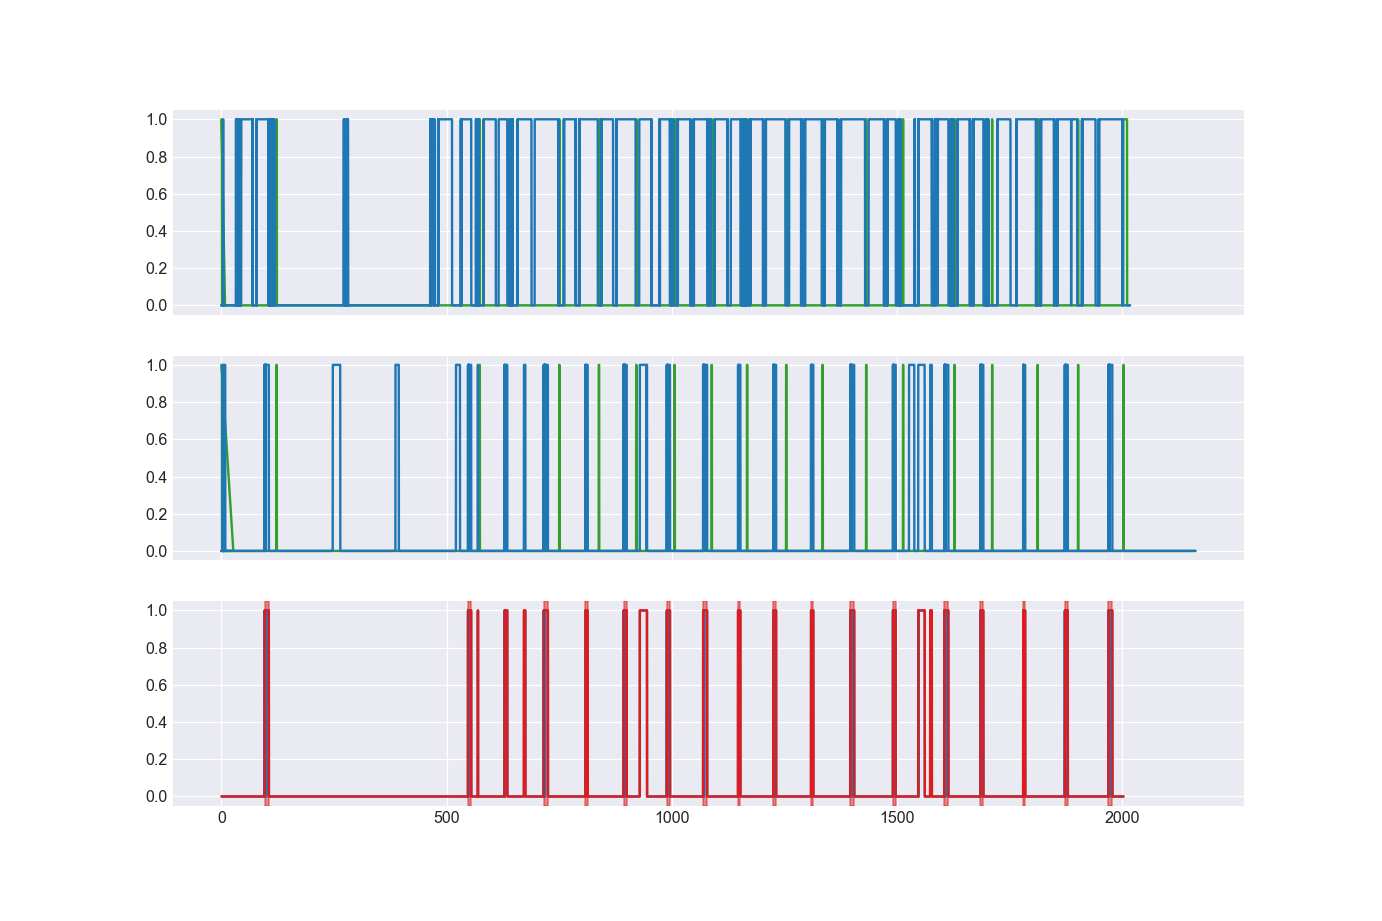

In [37]:
colors = sns.color_palette('Paired', 12)[1::2]
plt.close('all')
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(r.bicycle.time, r.bicycle.sync, color=colors[1])
ax[0].plot(r.bicycle.time, r.bicycle.speed > 1, color=colors[0])

ax[1].plot(r.lidar.time, r.lidar.sync, color=colors[1])
#filter on x, y box defined by points (0, 0) and (110, 4)
ax[1].plot(r.lidar.time, r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1, color=colors[0])

ax[2].plot(r.bicycle.time[hf_range[0]:hf_range[-1]], event_mask, color=colors[0])
ax[2].plot(r.bicycle.time[hf_range[0]:hf_range[-1]], debounce(event_mask), color=colors[2])
for t0, t1 in te:
    ax[2].axvspan(r.bicycle.time[t0 + hf_range[0]],
                  r.bicycle.time[t1 + hf_range[0]],
                  color=colors[2],
                  alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


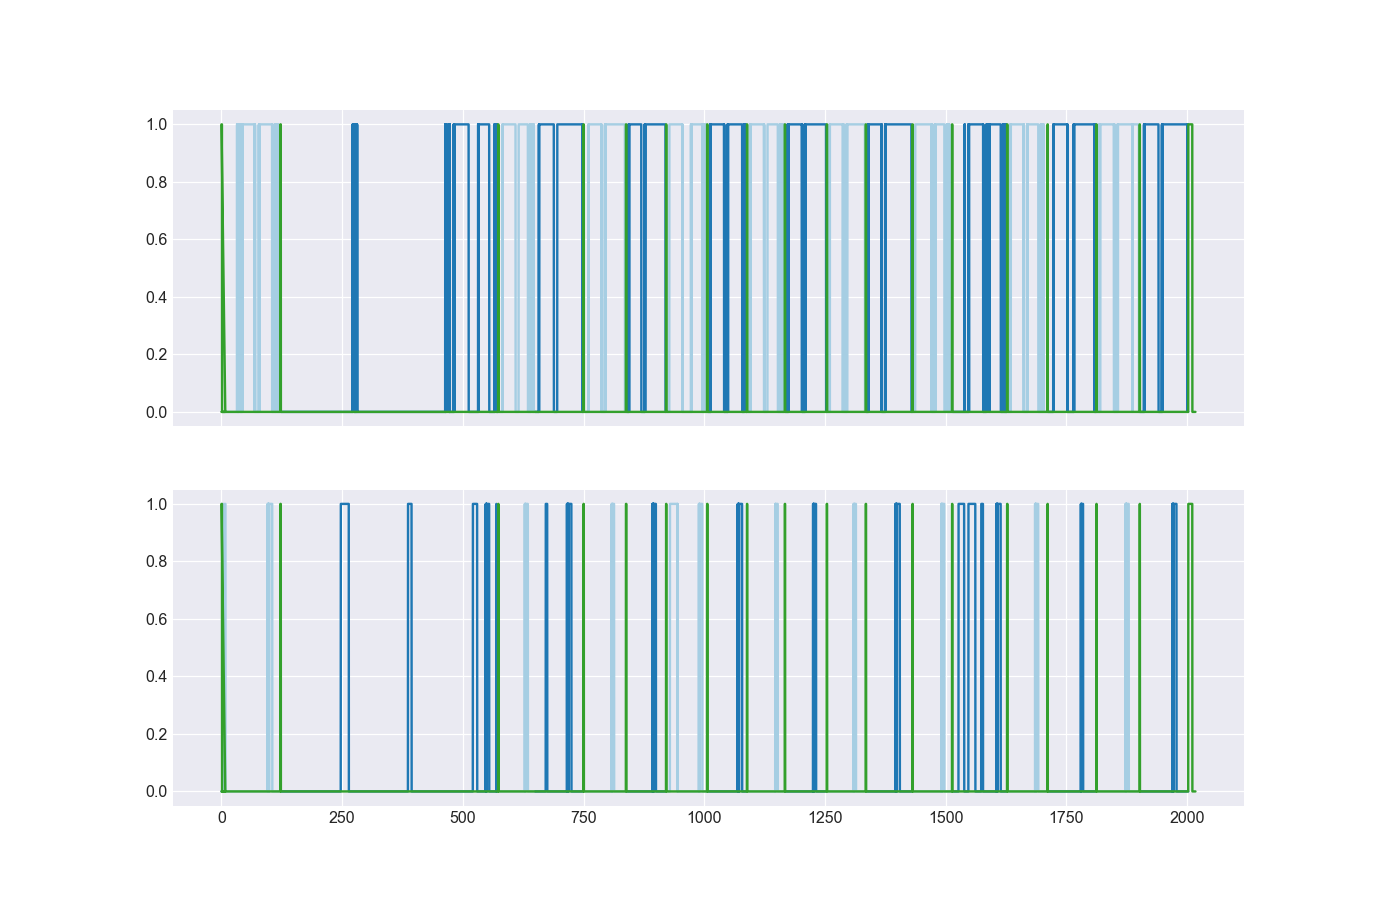

In [47]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

# denote missing sync signal at t=650 sec
r._calculate_trials2(missing_sync=[650])

plt.close()
colors = sns.color_palette('Paired', 12)
fig, ax = plt.subplots(2, 1, sharex=True)

i = 0
for t in r.trials:
    ax[0].plot(t.data.time, t.data.speed > 1, color=colors[i])
    ax[1].plot(t.lidar.time,
            t.lidar.cartesian(xlim=(0, 60), ylim=(0, 4))[0].count(axis=1) > 1,
            color=colors[i])
    i = i ^ 1
    
ax[0].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 
ax[1].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 
plt.show()